# Loading data & time conversion

In the TrainActivities.csv, all time-related columns are in JST but doesn't contain UTC information. 

While all accelerometer data are took in different time zones. 

Thus we need to add UTC information to activity labels dataset which is UTC+09:00

And convert all accelerometer data into the same timezone which is UTC+09:00

In [14]:
import pandas as pd
# load activity data
act_df = pd.read_csv('../data/TrainingDataPD25/TrainActivities.csv')
act_df.head()

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024/09/02 6:16,2024/09/02 6:16,2024/09/02 6:16,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:17,2024/09/02 6:17,2024/09/02 6:17,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024/09/02 6:18,2024/09/02 6:18,2024/09/02 6:18,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024/09/02 6:20,2024/09/02 6:20,2024/09/02 6:20,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024/09/02 6:42,2024/09/02 6:42,2024/09/02 6:42,U2


In [15]:
def convert_to_jst(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format='%Y/%m/%d %H:%M', errors='coerce')
        df[col] = df[col].dt.tz_localize('UTC+09:00')

cols = ['Started', 'Finished', 'Updated']
convert_to_jst(act_df, cols)

In [16]:
print(act_df['Started'].dt.tz)
display(act_df.head())

UTC+09:00


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2


In [2]:
"""
This dataset contains more than one timezones, but all of them include the UTC offset.
"""

# Load all csv files into one dataframe
import os
import glob
from datetime import timezone, timedelta

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'

headers = ['id', 'datetime', 'x', 'y', 'z']
df_list = [] # to store all csv files

for id in os.listdir(base_dir):
    path = os.path.join(base_dir, id)

    if os.path.isdir(path):
        files = glob.glob(os.path.join(path, '*.csv'))

        for f in files:
            df = pd.read_csv(f, header=None, names=headers) # load csv
            df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
            tz = df['datetime'].dt.tz # get the timezone
            if tz != 'UTC+09:00':
                df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
            df_list.append(df)

users_df = pd.concat(df_list, ignore_index=True)

In [3]:
users_df['datetime'].dt.tz

datetime.timezone(datetime.timedelta(seconds=32400))

In [50]:
users_df.head()

,id,datetime,x,y,z
0,2810,2024-09-10 06:25:37.059000+09:00,7.322,6.469,-0.548
1,2810,2024-09-10 06:25:37.075000+09:00,7.336,6.364,-0.586
2,2810,2024-09-10 06:25:37.084000+09:00,7.381,6.271,-0.612
3,2810,2024-09-10 06:25:37.093000+09:00,7.360,6.194,-0.624
4,2810,2024-09-10 06:25:37.102000+09:00,7.319,6.098,-0.619


# Matching activity labels with sensor data

In order to match the activity labels with the sensor data, we need to consider whether the timestamps in the sensor data are in the started and finished time of the activity or not. However, the started and finished in activity labels dataset do not contain any seconds, which makes no interval exists between started and finished.

Solution:
- Assume a activity started at H:min:00.000000 and finished at H:min:59.999999

In [17]:
act_df['started'] = act_df['Started'].dt.floor('s')
act_df['finished'] = act_df['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)

In [18]:
cols = ['Started', 'Finished', 'started', 'finished']
act_df[cols].head()

,Started,Finished,started,finished
0,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:59.999999+09:00
1,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:59.999999+09:00
2,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:59.999999+09:00
3,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:59.999999+09:00
4,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00


In [27]:
# Clean up the dataset
print('number of na rows per columns:')
display(act_df.isna().sum())
cols = ['Activity Type', 'Started', 'Finished']
print(f'number of duplicated activity rows: {act_df.duplicated(subset=cols, keep='last').sum()}')
print(f'act_df shape: {act_df.shape}')

number of na rows per columns:


ID                   0
Activity Type ID     0
Activity Type        0
Started             66
Finished            67
Updated              0
Subject              0
started             66
finished            67
dtype: int64

number of duplicated activity rows: 128
act_df shape: (342, 9)


From the above, we can see that this dataset is really bad. We need to clean the na, and duplicated rows.

In [34]:
# drop na rows in act_df and sort by subject
# test_df = act_df.copy()
act_df = act_df.dropna()
cols = ['Activity Type', 'Started', 'Finished']
act_df = act_df.drop_duplicates(subset=cols, keep='last')
act_df = act_df.sort_values(by=['Subject', 'started'])

act_df = act_df.reset_index(drop=True)
print(f'act_df shape: {act_df.shape}')
display(act_df.head())
# del test_df

act_df shape: (203, 9)


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject,started,finished
0,1130306,2806,1 (FACING camera) Sit and stand,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,U1,2024-09-02 06:44:00+09:00,2024-09-02 06:44:59.999999+09:00
1,1137246,2806,1 (FACING camera) Sit and stand,2024-09-03 21:21:00+09:00,2024-09-03 21:21:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:21:00+09:00,2024-09-03 21:21:59.999999+09:00
2,1137278,2806,1 (FACING camera) Sit and stand,2024-09-03 21:22:00+09:00,2024-09-03 21:22:00+09:00,2024-09-03 21:38:00+09:00,U1,2024-09-03 21:22:00+09:00,2024-09-03 21:22:59.999999+09:00
3,1137252,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-03 21:23:00+09:00,2024-09-03 21:23:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:23:00+09:00,2024-09-03 21:23:59.999999+09:00
4,1137255,2808,3 Stand up from chair - both hands with SHAKING,2024-09-03 21:24:00+09:00,2024-09-03 21:24:00+09:00,2024-09-03 21:42:00+09:00,U1,2024-09-03 21:24:00+09:00,2024-09-03 21:24:59.999999+09:00


In [36]:
"""
Segmenting the dataset into one dataframe per activity
Description:
- Each activity will has its own dataframe, which contains all the timestamps and accelerometer data within the activity time range.
"""
from datetime import timedelta

seg_label_list = [] # segment's (1 sample's) label list (label mean "activity_type_id", "user_id" etc.).
seg_list = [] # segment's (1 sample's) accelerometer data list.

for i in list(act_df.index):
    started_at = act_df.iloc[i]['started']
    finished_at = act_df.iloc[i]['finished']
    seg = users_df[(users_df['datetime'] >= started_at) & (users_df['datetime'] <= finished_at)]
    seg_label = act_df.iloc[i]['Activity Type']
    # check if seq is not empty
    if len(seg) != 0:
        seg_list.append(seg)
        seg_label_list.append(seg_label)

In [37]:
print(f'seg_list: {len(seg_list)}, seg_label_list: {len(seg_label_list)}')

seg_list: 199, seg_label_list: 199


# Feature Extraction

In [40]:
print(f'Started date: {act_df['Started'].dt.date.min()}')
print(f'Finished date: {act_df['Started'].dt.date.max()}')

Started date: 2024-09-02
Finished date: 2024-09-11


From the above results, we can know that the year and month values are not important. So that, we can extract the date only then drop year and month

In [47]:
tmp_df = act_df.copy()
tmp_df['date'] = tmp_df['Started'].dt.hour
tmp_df.sort_values(inplace=True, by='date', ignore_index=True)
tmp_df['date']

0       4
1       4
2       4
3       5
4       5
       ..
198    21
199    21
200    21
201    21
202    21
Name: date, Length: 203, dtype: int32

In [53]:
import numpy as np
"""
Creator: Krisna

Extracting std, mean, max and min from accelerometer data of each activity.

Returns:
    feats: List of features (which are std, mean, max, min)
Args:
    df: dataframe
Usages:
    feats_list = []
    for df in seg_list:
        feats_list.append(get_feats(df))
"""
def get_feats(df, columns=['x', 'y', 'z']):
    feats = []
    for col in columns:
        std_ = df[col].std(ddof=0)
        mean_ = np.average(df[col])
        max_ = np.max(df[col])
        min_ = np.min(df[col])
        feats.extend([std_, mean_, max_, min_])

    return feats

In [54]:
feats_list = []
for df in seg_list:
    feats_list.append(get_feats(df))

In [56]:
len(feats_list)

199

# Training

In [58]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats_list, seg_label_list, test_size=0.3, shuffle=True, random_state=42)

In [60]:
print(f"X_train : {np.array(X_train).shape}, Y_train : {np.array(y_train).shape}")
print(f"X_test : {np.array(X_test).shape}, Y_test : {np.array(y_test).shape}")

X_train : (139, 12), Y_train : (139,)
X_test : (60, 12), Y_test : (60,)


In [61]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [62]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))
# confusion_matrix(y_test, y_predict)

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.00      0.00      0.00         3
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.80      0.80      0.80         5
         2 (FACING camera) both hands SHAKING (sitting position)       0.33      0.29      0.31         7
                 3 Stand up from chair - both hands with SHAKING       0.20      0.50      0.29         4
                                         4 (Sideway) Sit & stand       0.00      0.00      0.00         9
                        5 (Sideway) both hands SHAKING (sitting)       0.33      0.25      0.29         8
                  6 (Sideway) STAND up with - both hands SHAKING       0.20      0.29      0.24         7
                                     7 Cool down - sitting/relax       0.00      0.00      0.00         3
                                8 Walk (LEFT 

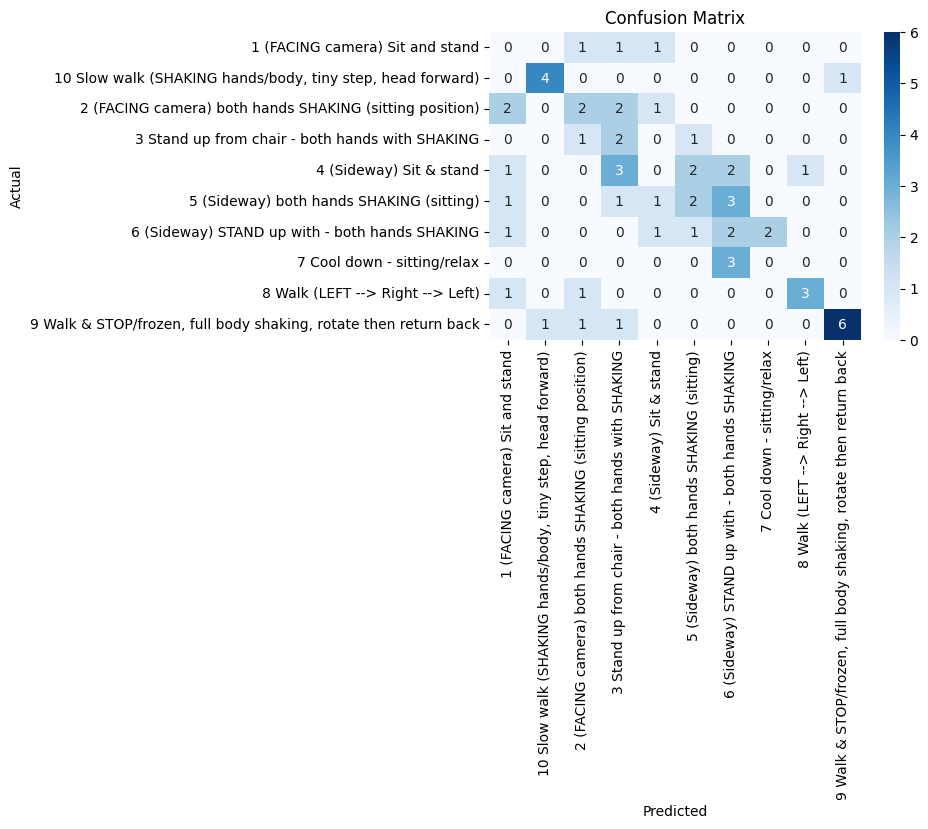

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# compute confusion matrix
cm = confusion_matrix(y_test, y_predict)
labels = np.unique(y_test)

# Plot with seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()